## NLTK를 이용한 NER

In [1]:
!pip install nltk

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [3]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"
# 토큰화 후 품사 태깅
tokenized_sentence = pos_tag(word_tokenize(sentence))
print(tokenized_sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [4]:
# 개체명 인식
ner_sentence = ne_chunk(tokenized_sentence)
print(ner_sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


## BiLSTM을 이용한 NER

In [5]:
import urllib.request
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/12.%20RNN%20Sequence%20Labeling/dataset/train.txt", filename="train.txt")

('train.txt', <http.client.HTTPMessage at 0x7cf723229270>)

### 데이터 로드 & 토크나이징

In [7]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14041


In [8]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [9]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


eu, german, british에 대해서 ner_tags가 지정된 것을 확인할 수 있다(나머지는 O)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentences, ner_tags, test_size=.2, random_state=777)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=777)
print('훈련 데이터의 개수 :', len(X_train))
print('검증 데이터의 개수 :', len(X_valid))
print('테스트 데이터의 개수 :', len(X_test))
print('훈련 데이터 레이블의 개수 :', len(X_train))
print('검증 데이터 레이블의 개수 :', len(X_valid))
print('테스트 데이터 레이블의 개수 :', len(X_test))

훈련 데이터의 개수 : 8985
검증 데이터의 개수 : 2247
테스트 데이터의 개수 : 2809
훈련 데이터 레이블의 개수 : 8985
검증 데이터 레이블의 개수 : 2247
테스트 데이터 레이블의 개수 : 2809


In [11]:
for sent in X_train[:2]:
  print(sent)

['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
['hentgen', '(', '17-7', ')', 'surrendered', 'just', 'three', 'doubles', 'and', 'a', 'pair', 'of', 'singles', 'in', 'tossing', 'his', 'major-league', 'leading', 'ninth', 'complete', 'game', '.']


### Vocab 만들기

In [12]:
from collections import Counter
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 16742


In [13]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'of', 'in', 'to', 'a', ')', '(', 'and']


### [For 데이터] Word_to_Index로 정수 인코딩

In [14]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 16744


In [15]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 the와 맵핑되는 정수 :', word_to_index['the'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 the와 맵핑되는 정수 : 2


In [18]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try: # 사전에 있는 경우 해당 단어의 정수 인코딩 값으로 변환
          index_sequences.append(word_to_index[word])
      except KeyError: # OOV의 경우 UNK 토큰의 정수 인코딩 값으로 처리
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

for sent, encoded_sent in zip(X_train[:2], encoded_X_train[:2]):
  print(sent)
  print(encoded_sent)
  print()

['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
[1260, 3215, 117, 17, 21, 123, 56, 539, 23]

['hentgen', '(', '17-7', ')', 'surrendered', 'just', 'three', 'doubles', 'and', 'a', 'pair', 'of', 'singles', 'in', 'tossing', 'his', 'major-league', 'leading', 'ninth', 'complete', 'game', '.']
[5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]



### [For 데이터] Index_to_word로 인코딩된 정수값을 다시 단어로 Decoding

In [19]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']
복원된 첫번째 샘플 : ['young', 'boys', '9', '1', '0', '8', '6', '19', '3']


### [For 레이블] Tag_to_Index로 label인 POS Tag를 정수 인코딩

In [20]:
# 레이블(여기서는 POS TAG)에 대한 정수 인코딩
# y_train으로부터 존재하는 모든 태그들의 집합 구하기
flatten_tags = [tag for sent in y_train for tag in sent] # y_train의 모든 문장에 대해 문장 안 tag들을 리스트로
tag_vocab = list(set(flatten_tags))
print('태그 집합 :', tag_vocab)
print('태그 집합의 크기 :', len(tag_vocab))

태그 집합 : ['O', 'B-MISC', 'I-PER', 'I-MISC', 'I-ORG', 'B-PER', 'B-LOC', 'B-ORG', 'I-LOC']
태그 집합의 크기 : 9


In [21]:
# Tag를 정수 인코딩 값으로 변환하는 작업
tag_to_index = {}
tag_to_index['<PAD>'] = 0 # UNK의 경우 이미 O로 처리되기 때문에 PAD만 추가

for index, word in enumerate(tag_vocab) :
  tag_to_index[word] = index + 1

tag_vocab_size = len(tag_to_index)
# print('패딩 토큰까지 포함된 태그 집합의 크기 :', tag_vocab_size)
print('태그 집합 :', tag_to_index)

태그 집합 : {'<PAD>': 0, 'O': 1, 'B-MISC': 2, 'I-PER': 3, 'I-MISC': 4, 'I-ORG': 5, 'B-PER': 6, 'B-LOC': 7, 'B-ORG': 8, 'I-LOC': 9}


태그는 총 10개가 존재했다. 아래 4개에 대해 B, I로 2개씩 존재하고 <PAD>와 O를 추가해서 총 10개이다
- PER : PERSON
- LOC : LOCATION
- ORG : ORGANIZATION
- MISC : Miscellaneous(잡다)

In [22]:
# tag들의 sequence에서 tag의 정수 인덱스로 encoding하는 함수
def encoding_label(sequence, tag_to_index):
  label_sequence = []
  for seq in sequence:
    label_sequence.append([tag_to_index[tag] for tag in seq])
  return label_sequence

In [23]:
encoded_y_train = texts_to_sequences(y_train, tag_to_index)
encoded_y_valid = texts_to_sequences(y_valid, tag_to_index)
encoded_y_test = texts_to_sequences(y_test, tag_to_index)

In [24]:
print('X 데이터 상위 2개')
print(encoded_X_train[:2])
print('-' * 50)
print('y 데이터 상위 2개')
print(encoded_y_train[:2])
print('-' * 50)
print('첫번째 샘플과 레이블의 길이')
print(len(encoded_X_train[0]))
print(len(encoded_y_train[0]))

X 데이터 상위 2개
[[1260, 3215, 117, 17, 21, 123, 56, 539, 23], [5456, 10, 8229, 9, 8230, 186, 84, 1815, 11, 8, 1073, 5, 421, 6, 8231, 35, 2043, 291, 790, 957, 267, 4]]
--------------------------------------------------
y 데이터 상위 2개
[[8, 5, 1, 1, 1, 1, 1, 1, 1], [6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
--------------------------------------------------
첫번째 샘플과 레이블의 길이
9
9


### [For 레이블] 정수 인코딩된 인덱스로부터 원래의 POS Tag를 복원(Decoding)

In [34]:
index_to_tag = {}
for key, value in tag_to_index.items():
  index_to_tag[value] = key

In [39]:
index_to_tag[0], index_to_tag[1], index_to_tag[2]

('<PAD>', 'O', 'B-MISC')

### Padding

샘플의 최대 길이 : 78
샘플의 평균 길이 : 14.518420


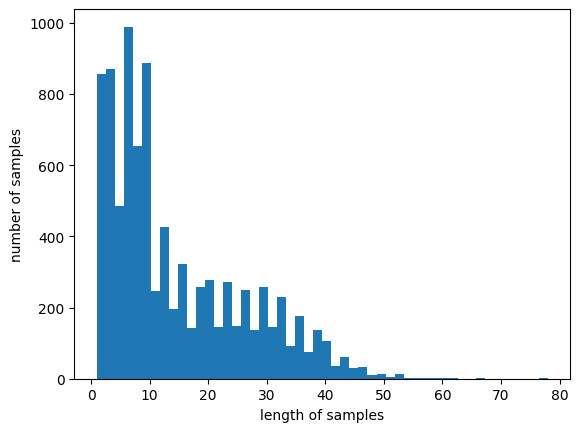

In [25]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in encoded_X_train))
print('샘플의 평균 길이 : %f' % (sum(map(len, encoded_X_train))/len(encoded_X_train)))
plt.hist([len(s) for s in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
# max_len을 정하기 위해 해당 길이의 전체 비율을 체크하는 함수를 제작
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [27]:
# 최대길이가 78이기 때문에 80으로 padding해도 되긴 함
max_len = 80
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [28]:
max_len = 50
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.67723984418475


In [30]:
# padding 함수
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int) # 일단 max_len만큼 0으로 초기화하고
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len] # sentence에 기존 값(정수 인코딩 sequence)는 그대로 덮어 써준다
    return features

In [31]:
padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

padded_y_train = pad_sequences(encoded_y_train, max_len=max_len)
padded_y_valid = pad_sequences(encoded_y_valid, max_len=max_len)
padded_y_test = pad_sequences(encoded_y_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)
print('-' * 30)
print('훈련 데이터의 레이블 :', padded_y_train.shape)
print('검증 데이터의 레이블 :', padded_y_valid.shape)
print('테스트 데이터의 레이블 :', padded_y_test.shape)

훈련 데이터의 크기 : (8985, 50)
검증 데이터의 크기 : (2247, 50)
테스트 데이터의 크기 : (2809, 50)
------------------------------
훈련 데이터의 레이블 : (8985, 50)
검증 데이터의 레이블 : (2247, 50)
테스트 데이터의 레이블 : (2809, 50)


In [32]:
print('훈련 데이터의 상위 샘플 2개')
print(padded_X_train[:2])
print('-' * 5 + '레이블' + '-' * 5)
print(padded_y_train[:2])

훈련 데이터의 상위 샘플 2개
[[1260 3215  117   17   21  123   56  539   23    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [5456   10 8229    9 8230  186   84 1815   11    8 1073    5  421    6
  8231   35 2043  291  790  957  267    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
-----레이블-----
[[8 5 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Modeling

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cuda


In [49]:
class NERTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(NERTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True) # 단방향 GRU를 사용하는 경우
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True) # 양방향 LSTM을 사용하는 경우
        # self.fc = nn.Linear(hidden_dim, output_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        # gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_length, hidden_dim*2)
        # logits = self.fc(gru_out)  # (batch_size, seq_length, output_dim)
        logits = self.fc(lstm_out)  # (batch_size, seq_length, output_dim)
        return logits

In [41]:
# 데이터와 레이블을 모두 tensor 형식으로 변환하고
X_train_tensor = torch.tensor(padded_X_train, dtype=torch.long)
y_train_tensor = torch.tensor(padded_y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(padded_X_valid, dtype=torch.long)
y_valid_tensor = torch.tensor(padded_y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(padded_X_test, dtype=torch.long)
y_test_tensor = torch.tensor(padded_y_test, dtype=torch.long)
# TensorDataset으로 데이터셋을 구축 --> DataLoader로 Iterator 생성
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=32)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [50]:
embedding_dim = 100 # 각 단어의 embedding 차원
hidden_dim = 256    # BiLSTM의 hidden state의 차원 크기
output_dim = tag_vocab_size # output의 차원은 전체 vocab 크기가 되어야 각 값들에 대한 확률값으로 나오고 그중 최대를 선택할 것
learning_rate = 0.01
num_epochs = 10
num_layers = 2 # BiLSTM의 layer가 2개

In [51]:
# Model, loss, optimizer
model = NERTagger(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0) # 0번째 index에 대한 loss 계산은 제외 = <PAD> 토큰은 모델 학습시 의미가 없으므로 손실 계산에서 무시
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
def calculate_accuracy(logits, labels, ignore_index=0):
    # 예측 레이블을 구합니다.
    predicted = torch.argmax(logits, dim=1) #

    # 패딩 토큰은 무시합니다.
    mask = (labels != ignore_index)

    # 정답을 맞춘 경우를 집계합니다.
    correct = (predicted == labels).masked_select(mask).sum().item()
    total = mask.sum().item()

    accuracy = correct / total
    return accuracy

def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            # batch_X.shape = [batch_size, sequence_length, embedding_dim]
            logits = model(batch_X) # logits.shape = [batch_size, sequence_length, output_dim(=vocab_size)]
            loss = criterion(logits.view(-1, output_dim), batch_y.view(-1))
            # logits.view(-1, output_dim) = [batch_size, sequence_length, output_dim]인 logits의 shape을 [batch_size * sequence_length, output_dim]으로 변경
            # batch_y.view(-1) = [batch_size, sequence_length]인 batch_y의 shape을 [batch_size * sequence_length]로 변경
            # batch_size * sequence_length는 total time step이고 배치 내의 모든 time step에 대해 각각의 경우 output_dim(vocab_size)마다의 로짓값이 softmax가 취해져서 확률값이 되고
            # 그 확률값들 중에서 batch_y가 가리키는 정답 인덱스에 해당되는 확률값에 NLL(Negative Log-Likelihood)가 적용되며 이것이 손실값이 된다
            # 그리고 정답 인덱스가 가리키는 확률값이 클수록 log_likelihood는 작아지며 그렇기 때문에 정답에 대한 확률이 높을수록 손실이 작게 계산되는 구조이다
            # 그리고 이렇게 계산된 손실에 gradient를 계산하고 gradient를 줄이는 방향으로 학습을 진행하여 학습 후에 정답 인덱스에 대한 확률값이 높아지는 방향으로 파라미터가 학습되는 것이다

            val_loss += loss.item()
            val_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [53]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) # GPU에 올리고
        logits = model(batch_X) # Forward Pass
        loss = criterion(logits.view(-1, output_dim), batch_y.view(-1)) # logits을 실제 정답(레이블)과 비교하여 CrossEntropyLoss를 계산하고

        optimizer.zero_grad() # 이전에 계산되어 있는 gradient를 초기화한 후
        loss.backward()       # Backward pass: 해당 batch에서 계산된 손실(loss)를 바탕으로 모든 파라미터에 대한 gradient를 계산
        optimizer.step()      # 계산된 gradient로 parameter update를 수행

        train_loss += loss.item()
        train_correct += calculate_accuracy(logits.view(-1, output_dim), batch_y.view(-1)) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/10:
Train Loss: 0.4269, Train Accuracy: 0.8846
Validation Loss: 0.2386, Validation Accuracy: 0.9324
Validation loss improved from inf to 0.2386. 체크포인트를 저장합니다.
Epoch 2/10:
Train Loss: 0.1334, Train Accuracy: 0.9612
Validation Loss: 0.1761, Validation Accuracy: 0.9529
Validation loss improved from 0.2386 to 0.1761. 체크포인트를 저장합니다.
Epoch 3/10:
Train Loss: 0.0595, Train Accuracy: 0.9827
Validation Loss: 0.2337, Validation Accuracy: 0.9512
Epoch 4/10:
Train Loss: 0.0357, Train Accuracy: 0.9892
Validation Loss: 0.2276, Validation Accuracy: 0.9548
Epoch 5/10:
Train Loss: 0.0235, Train Accuracy: 0.9929
Validation Loss: 0.2273, Validation Accuracy: 0.9567
Epoch 6/10:
Train Loss: 0.0225, Train Accuracy: 0.9930
Validation Loss: 0.2293, Validation Accuracy: 0.9563
Epoch 7/10:
Train Loss: 0.0211, Train Accuracy: 0.9934
Validation Loss: 0.2260, Validation Accuracy: 0.9563
Epoch 8/10:
Train Loss: 0.0194, Train Accuracy: 0.9937
Validation Loss: 0.2354, Validation Accuracy: 0.9581
Epoch 9/10:
Tra

In [54]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도(accuracy)와 손실(loss) 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

<ipython-input-54-7865f128b618>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_checkpoint.pth'))


Best model validation loss: 0.1761
Best model validation accuracy: 0.9529


In [55]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.1707
Best model test accuracy: 0.9536


In [60]:
def predict_labels(text, model, word_to_ix, index_to_tag, max_len=150):
    # 단어 토큰화
    tokens = text.split()

    # 정수 인코딩
    token_indices = [word_to_ix.get(token, 1) for token in tokens]

    # 패딩
    token_indices_padded = np.zeros(max_len, dtype=int)
    token_indices_padded[:len(token_indices)] = token_indices[:max_len]

    # 텐서로 변환
    input_tensor = torch.tensor(token_indices_padded, dtype=torch.long).unsqueeze(0).to(device)

    # 모델의 입력으로 사용하고 예측값 리턴
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)

    # 가장 값이 높은 인덱스를 예측값으로 선택
    predicted_indices = torch.argmax(logits, dim=-1).squeeze(0).tolist()

    # 패딩 토큰 제거
    predicted_indices_no_pad = predicted_indices[:len(tokens)]

    # 패딩 토큰을 제외하고 정수 시퀀스를 예측 시퀀스로 변환
    predicted_tags = [index_to_tag[index] for index in predicted_indices_no_pad]

    return predicted_tags

In [61]:
print(X_test[0])

['feyenoord', 'rotterdam', 'suffered', 'an', 'early', 'shock', 'when', 'they', 'went', '1-0', 'down', 'after', 'four', 'minutes', 'against', 'de', 'graafschap', 'doetinchem', '.']


In [62]:
sample = ' '.join(X_test[0])
print(sample)

feyenoord rotterdam suffered an early shock when they went 1-0 down after four minutes against de graafschap doetinchem .


In [63]:
predicted_tags = predict_labels(sample, model, word_to_index, index_to_tag)
print('예측 :', predicted_tags)
print('실제값 :', y_test[0])

예측 : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'B-MISC', 'I-PER', 'O']
실제값 : ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']
